In [439]:
import numpy as np
import matplotlib.pyplot as plt

### Let's start simple by implementing a neural network with one scalar input, one neuron, and one scalar output. 

We will be using the identity mapping as our activation function, i.e. $g(z=wx+b)=z$.

In [440]:
def g(z):
    return z

In [441]:
def forward(x, w, b):
    return g(w * x + b)

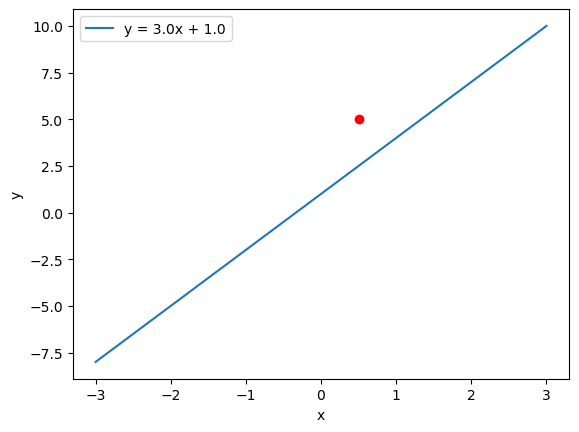

In [442]:
w = 3.0
b = 1.0

xs = np.linspace(-3, 3, 1000)
preds = [forward(x, w, b) for x in xs]

plt.plot(xs, preds, label=f"y = {w}x + {b}")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# also plot outlier point we are going to fit
red_x, red_y = (0.5, 5)
plt.plot(red_x, red_y, "ro", label=f"({red_x}, {red_y})")

plt.show()

### Obviously the neural network we've defined absolutely sucks!

Let's try and fix that.

# Loss function: Squared error

In [515]:
def error(y_pred, y_true):
    err = y_true - y_pred
    return err * err

### Derivative of the error with respect to the neural-network output $\frac{\partial e}{\partial y}$

A small nudge in $a = g(z=wx+b)$ causes a small nudge in the error...

In [516]:
def de_dz(y_pred, y_true):
    derivative = -2 * (y_true - y_pred)
    return derivative

### Derivative of $z$ with respect to the parameter $w$: $\frac{\partial z}{\partial w}$

... and a small nudge of $w$ causes a small nudge in $z$...

In [517]:
def dz_dw(x):
    # neuron computes z=wx+b => dz/dw = x
    derivative = x
    return derivative

### Derivative of the $z$ with respect to the parameter $b$: $\frac{\partial z}{\partial b}$

... and a small nudge of $b$ also causes a small nudge in $z$.

In [518]:
def dz_db():
    # neuron computes z=wx+b => dz/db = 1
    derivative = 1
    return derivative

### Now we can express how the error changes whenever we change the parameters $w$ and $b$.

The [Chain rule](https://en.wikipedia.org/wiki/Chain_rule) is my friend here.

### Derivative of $e$ with respect to the parameter $w$: $\frac{\partial e}{\partial w}$

In [519]:
def de_dw(x, y_pred, y_true):
    # a small nudge in w causes a small nudge in z... which causes a small nudge in e
    derivative = dz_dw(x) * de_dz(y_pred, y_true)
    return derivative

### Derivative of $e$ with respect to the parameter $b$: $\frac{\partial e}{\partial b}$

In [520]:
def de_db(y_pred, y_true):
    # a small nudge in b causes a small nudge in z... which causes a small nudge in e
    derivative = dz_db() * de_dz(y_pred, y_true)
    return derivative

## We are now ready to do some training!

We start by quickly defining a 'step' function (similar to what `optimizer.step()` is in Pytorch) which updates the parameters.

In [521]:
def step(w, b, dedw, dedb, learning_rate=1e-1):
    w -= learning_rate * dedw
    b -= learning_rate * dedb
    return w, b

Now we train!

Let's try and fit our neural network to the red point shown earlier.

In [522]:
def fit(x, w, b, y_true, iterations=10, learning_rate=1e-3):
    for i in range(iterations):
        y_pred = w*x + b
        dedw = de_dw(x, y_pred, y_true)
        dedb = de_db(y_pred, y_true)
        w, b = step(w, b, dedw, dedb, learning_rate)
        print(f"Iteration {i + 1} | Error: {error(y_true, y_pred)}")
    return w, b

In [523]:
# red_point = (red_x, red_y)
print(f"old_w={w}, old_b={b}\n")
w_opt, b_opt = fit(red_x, w, b, red_y, iterations=10, learning_rate=1e-1)
print(f"\nnew_w={w_opt}, new_b={b_opt}")

old_w=3.0, old_b=1.0

Iteration 1 | Error: 6.25
Iteration 2 | Error: 3.515625
Iteration 3 | Error: 1.9775390625
Iteration 4 | Error: 1.11236572265625
Iteration 5 | Error: 0.6257057189941406
Iteration 6 | Error: 0.3519594669342041
Iteration 7 | Error: 0.1979772001504898
Iteration 8 | Error: 0.11136217508465052
Iteration 9 | Error: 0.06264122348511592
Iteration 10 | Error: 0.0352356882103777

new_w=3.9436864852905273, new_b=2.8873729705810547


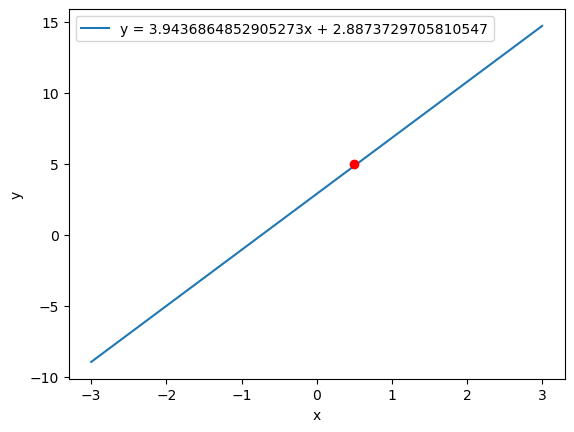

In [524]:
xs = np.linspace(-3, 3, 1000)
preds = [forward(x, w_opt, b_opt) for x in xs]

plt.plot(xs, preds, label=f"y = {w_opt}x + {b_opt}")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# also plot outlier point we are going to fit
plt.plot(red_x, red_y, "ro", label=f"({red_x}, {red_y})")

plt.show()

# Great Success! Very Nice!

We managed to fit a straight line to one data point, incredible! It's truly amazing what you can do with AI......yeah.

### Alright, cool... I guess?

#### Let's start doing some more fun stuff.

We're going to enlist the good ol' [Rectified Linear Unit (ReLU)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) to act as our activation function $g(z) = ReLU(z)$.

In [525]:
def ReLU(z):
    return np.maximum(z, 0)

def ReLU_derivative(x):
    return np.greater(x, 0).astype(int)

#### Let's implement another activation function [Softmax](https://en.wikipedia.org/wiki/Softmax_function) which we'll use shortly.

In [527]:
def Softmax(z):
    z_max = z - np.max(z, axis=1, keepdims=True)
    exp_z_max = np.exp(z_max)
    return exp_z_max / np.sum(exp_z_max, axis=1, keepdims=True)

#### Cool, cool, cool, cool.

While we're at it, let's abstract away some stuff...

In [528]:
class Layer:
    def __init__(self):
        # For simplicity's sake, let's hard code the use of ReLU as the activation function for a layer.
        self.g = ReLU
        self.g_derivative = ReLU_derivative

        # He initialization: https://www.deeplearning.ai/ai-notes/initialization/index.html
        self.w = np.random.rand() * np.sqrt(2)
        self.b = 0

        self.input = None
        self.activation = None

    def forward(self, x):
        self.input = x

        activation = self.g(self.w*x + self.b)
        self.activation = activation

        return activation

    def backward(self, deda, learning_rate=1e-2):
        dzdw = dz_dw(self.input)
        dzdb = dz_db()

        dadz = self.g_derivative(self.activation)
        
        dadz_deda = dadz * deda
        dedw = dzdw * dadz_deda
        dedb = dzdb * dadz_deda

        # update parameters
        self.w -= learning_rate * dedw
        self.b -= learning_rate * dedb

        dzdx = self.w
        dedx = dzdx * dadz_deda

        return dedx

In [530]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []

    def add_layer(self, layer):
        self.layers.append(layer)
        return self

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, deda, learning_rate=1e-2):
        for layer in self.layers[::-1]: # notice in reverse!
            deda = layer.backward(deda, learning_rate)

### Let's test this bad boy out with almost the same example as earlier.

In [531]:
neural_network = NeuralNetwork()

# Two layers this time, we're getting fancy over here!
l1 = Layer()
l2 = Layer()
neural_network.add_layer(l1).add_layer(l2)

print(f"# of hidden layers = {len(neural_network.layers)}")

# of hidden layers = 2


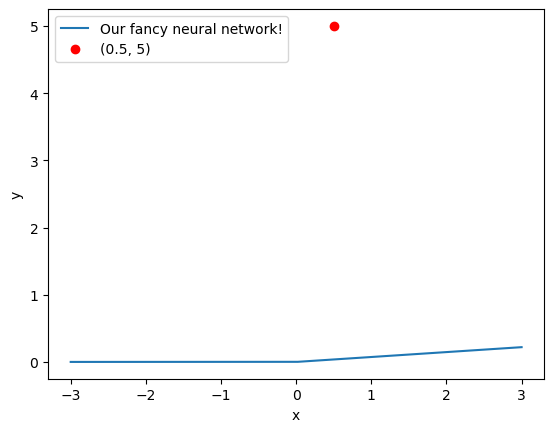

In [532]:
xs = np.linspace(-3, 3, 1000)
preds = neural_network.forward(xs) # vectorized implementation, nice!

plt.plot(xs, preds, label=f"Our fancy neural network!")

plt.xlabel("x")
plt.ylabel("y")

# also plot outlier point we are going to fit
plt.plot(red_x, red_y, "ro", label=f"({red_x}, {red_y})")

plt.legend()
plt.show()

#### Yeah... what'd you expect?

Let's train it.

In [533]:
def train(model, x, y_true, iterations=10, learning_rate=1e-2):
    for i in range(iterations):
        y_pred = model.forward(x)
        deda = de_dz(y_pred, y_true)
        model.backward(deda)
        print(f"Iteration {i + 1} | Error: {error(y_pred, y_true)}")

In [535]:
train(neural_network, red_x, red_y, iterations=15, learning_rate=1e-1)

Iteration 1 | Error: 5.352245234432288
Iteration 2 | Error: 4.401840407645961
Iteration 3 | Error: 3.560396997046081
Iteration 4 | Error: 2.832191081106218
Iteration 5 | Error: 2.2163040084173247
Iteration 6 | Error: 1.7071103825262797
Iteration 7 | Error: 1.2952883345826065
Iteration 8 | Error: 0.9691115676910597
Iteration 9 | Error: 0.7157673424937743
Iteration 10 | Error: 0.5224957571734969
Iteration 11 | Error: 0.37743255516629237
Iteration 12 | Error: 0.27012584605934137
Iteration 13 | Error: 0.19176270520615213
Iteration 14 | Error: 0.13517622998974269
Iteration 15 | Error: 0.09471112989248388


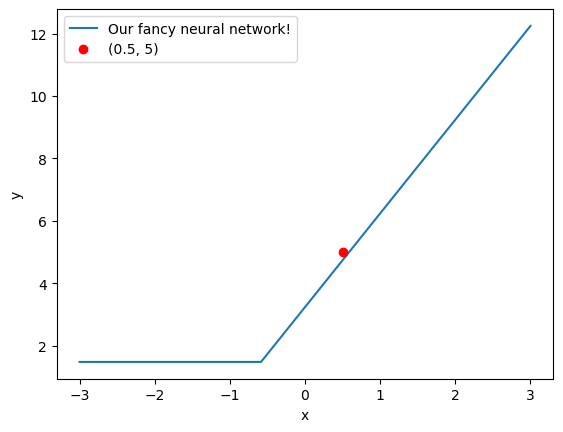

In [536]:
xs = np.linspace(-3, 3, 1000)
preds = neural_network.forward(xs) # vectorized implementation, nice!

plt.plot(xs, preds, label=f"Our fancy neural network!")

plt.xlabel("x")
plt.ylabel("y")

# also plot outlier point we are going to fit
plt.plot(red_x, red_y, "ro", label=f"({red_x}, {red_y})")

plt.legend()
plt.show()

# Great Success! Very Nice!

#### Alright, let's level up again and start working with more than just some scalars.

#### Let's redefine our Layer

In [537]:
class Layer:
    def __init__(self, input_dim, output_dim, g=ReLU):
        self.g = g

        # He initialization
        stddev = np.sqrt(2.0 / input_dim)
        self.w = np.random.normal(loc=0.0, scale=stddev, size=(input_dim, output_dim))
        self.b = np.zeros((1, output_dim))

        self.input = None
        self.activation = None

    def forward(self, x):
        self.input = x

        z = np.dot(x, self.w) + self.b
        self.activation = self.g(z)

        return self.activation

    def backward(self, gradient, learning_rate=1e-2):
        if self.g == ReLU: # true for all layers except output layer
            gradient *= ReLU_derivative(self.activation)

        dedw = np.dot(self.input.T, gradient)
        dedb = np.sum(gradient, axis=0, keepdims=True)

        self.w -= learning_rate * dedw
        self.b -= learning_rate * dedb

        dzdx = self.w.T
        dedx = np.dot(gradient, dzdx)

        return dedx

#### ...and our Neural Network

In [538]:
class NeuralNetwork:
    def __init__(self, input_dim, layer_dims):
        self.layers = []

        nof_layers = len(layer_dims)
        layer_dims = [input_dim] + layer_dims
        for l in range(1, len(layer_dims)):
            # use ReLU for all layers except the output layer where we use Softmax
            act_fn = ReLU if l < nof_layers else Softmax
            self.layers.append(Layer(layer_dims[l - 1], layer_dims[l], act_fn))

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, gradient, lr):
        for layer in self.layers[::-1]:
            gradient = layer.backward(gradient, lr)

#### ...we're also going to need some utility functions

In [539]:
def loss(y_pred, y_true):
    epsilon = 1e-10
    p = np.clip(y_pred, epsilon, 1 - epsilon)

    # https://en.wikipedia.org/wiki/Likelihood_function
    # https://en.wikipedia.org/wiki/Cross-entropy
    log_likelihood = -np.sum(y_true * np.log(p)) / y_true.shape[0]

    return log_likelihood

def loss_grad(y_pred, y_true):
    return (y_pred - y_true) / y_true.shape[0]

#### ...and a new training function

In [540]:
def train(model, x_train, y_train, iters, lr):
    for i in range(iters):
        preds = model.forward(x_train)
        l = loss(preds, y_train)
        deda = loss_grad(preds, y_train)
        model.backward(deda, lr)
        print(f"Iteration {i + 1}/{iters} | Loss: {l:.2f}")

## Alright. We've got some basic machinery up and running, let's use it on a more fun example.

Gooooooood ooooold [MNIST](https://yann.lecun.com/exdb/mnist/)!

In [541]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)

In [542]:
x = mnist["data"].to_numpy()
y = mnist["target"].to_numpy()

# normalize data
x = x / 225.0
y = y.astype(int)

y_one_hot = np.zeros((y.size, y.max() + 1))
y_one_hot[np.arange(y.size), y] = 1

print(f"len(x) = {len(x)}")
print(f"len(y) = {len(y)}")

len(x) = 70000
len(y) = 70000


In [543]:
# 85/15 split

nof_train_samples = int(len(x) * 0.85)

x_train, x_test = x[:nof_train_samples], x[nof_train_samples:]
y_train, y_test = y_one_hot[:nof_train_samples], y_one_hot[nof_train_samples:]

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print()
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (59500, 784)
y_train shape: (59500, 10)

x_test shape: (10500, 784)
y_test shape: (10500, 10)


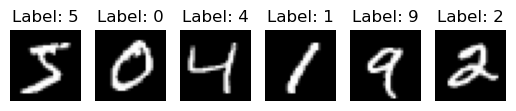

In [544]:
# let's take a quick look at some samples...
n_samples = 6
fig, axs = plt.subplots(1, n_samples)
for i in range(n_samples):
    axs[i].imshow(x_train[i].reshape(28, 28), cmap="gray")
    axs[i].set_title(f"Label: {np.argmax(y_train[i])}")
    axs[i].axis("off")
plt.show()

### Let's train our neural network to classify handwritten digits

In [545]:
def accuracy(model, x_test, y_test):
    preds = model.forward(x_test)

    predicted_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    correct = np.sum(predicted_labels == true_labels)

    acc = correct / x_test.shape[0]
    return acc

In [546]:
model = NeuralNetwork(784, [256, 256, 10])

acc_pre_train = accuracy(model, x_test, y_test)
print(f"Accuracy before training = {acc_pre_train}")

Accuracy before training = 0.10828571428571429


#### ... that's not particularly good.

#### ... let's train

In [547]:
train(model, x_train, y_train, 25, 1e-1)

Iteration 1/25 | Loss: 2.41
Iteration 2/25 | Loss: 2.23
Iteration 3/25 | Loss: 2.11
Iteration 4/25 | Loss: 1.99
Iteration 5/25 | Loss: 1.89
Iteration 6/25 | Loss: 1.78
Iteration 7/25 | Loss: 1.68
Iteration 8/25 | Loss: 1.58
Iteration 9/25 | Loss: 1.48
Iteration 10/25 | Loss: 1.39
Iteration 11/25 | Loss: 1.31
Iteration 12/25 | Loss: 1.23
Iteration 13/25 | Loss: 1.16
Iteration 14/25 | Loss: 1.09
Iteration 15/25 | Loss: 1.03
Iteration 16/25 | Loss: 0.98
Iteration 17/25 | Loss: 0.93
Iteration 18/25 | Loss: 0.89
Iteration 19/25 | Loss: 0.85
Iteration 20/25 | Loss: 0.81
Iteration 21/25 | Loss: 0.78
Iteration 22/25 | Loss: 0.76
Iteration 23/25 | Loss: 0.73
Iteration 24/25 | Loss: 0.71
Iteration 25/25 | Loss: 0.69


In [548]:
acc_after_train = accuracy(model, x_test, y_test)
print(f"Accuracy after training = {acc_after_train}")

Accuracy after training = 0.8537142857142858


### Let's visualize a prediction

In [549]:
def visualize_prediction(model, x_test, y_test, sample_idx):
    y_pred = model.forward(x_test[sample_idx : sample_idx + 1])
    plt.imshow(x_test[sample_idx].reshape(28, 28), cmap="gray")
    plt.title(
        f"Prediction: {np.argmax(y_pred)} | True label: {np.argmax(y_test[sample_idx])}"
    )
    plt.axis("off")
    plt.show()

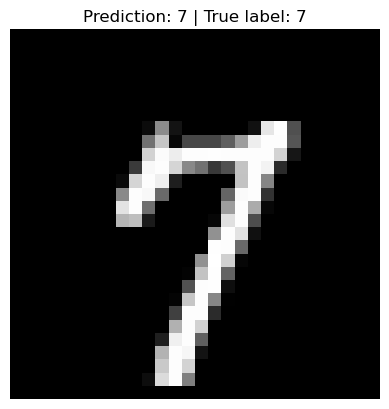

In [550]:
visualize_prediction(model, x_test, y_test, 13)

# Great Success! Very nice!